In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os.path
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit
import iminuit
import seaborn as sns
import awkward as ak

from progressbar import progressbar
import re

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [3]:
plt.style.use('pylib/cmd1202.mplstyle')

In [4]:
season = '19'
total_info_filename = f'../data/{season}/total_info_19.txt'
total_info = pd.read_csv(total_info_filename, index_col=0)

In [32]:
idx = 15
total_info.loc[idx]

elabel                                                        687.5_74169
emeas                                                          687.114319
exp_tree                root://sl10cmd//scan2019/scan2019_tr_ph_fc_e68...
lum_exp                                                           1156.47
lum_exp_err                                                       2.03725
mc_raw_kskl_mcgpj       /store17/petrov/data/kskl20/raw/19/kskl_687.5_...
mc_tree_kskl_mcgpj      /store17/petrov/data/kskl20/tr_ph/19/tr_ph_ksk...
mc_tree_kskl_uniform    /store17/petrov/data/kskl_uniform_individual/1...
mlt_raw                                                           45602.0
ksklpi0_raw                                                       45778.0
4pi_raw                                                               NaN
exp_csv                                     csv/19/tr_ph_fc_e687.5_v8.csv
Name: 15, dtype: object

In [33]:
trfile = uproot.open(f'/store17/petrov/data/kskl20/tr_ph/multi/19/tr_ph_run0{total_info.at[idx, "mlt_raw"]:.0f}.root')

In [34]:
cut0 = '(nt>=2)&(nks>0)'
pidedx = '5.58030e+9 / (tptot + 40.)**3 + 2.21228e+3 - 3.77103e-1 * tptot - tdedx'
deltap = 'tptot - sqrt((emeas/2)**2 - 139.57**2)'

In [35]:
def prepare_df(trfile, cut0):
    df_dc = ak.to_pandas(trfile['tr_ph'].arrays(['evnum', 'tth', 'tchi2r', 'tchi2z', 'tphi', 'trho', 'tz', 'pidedx', 'deltap', 'tptot'], 
                                            cut = cut0, aliases = {'pidedx' : pidedx, 'deltap': deltap})).reset_index().set_index(['evnum', 'subentry'])\
        .drop(['entry'], axis=1)
    df_dc.index = df_dc.index.rename(('evnum', 'ksvind'))
    
    df_ksall = ak.to_pandas(trfile['tr_ph'].arrays(['evnum', 'psumch', 'ksptot', 'ksdpsi', 'ksalign', 'ksth', 'ksphi', 'ksminv', 'deltam', 'delta_ksptot', 'finalstate_id'], cut = cut0, 
                                            aliases = {'deltam' : 'abs(ksminv - 497.6)',
                                                       'delta_ksptot': '(ksptot - sqrt(emeas**2 - 497.6**2))',
                                                      }))
    df_ksall = df_ksall.sort_values(by=['deltam']).drop_duplicates(subset=['evnum'], keep='first')
    df_ksall = df_ksall.reset_index().set_index(['evnum', 'subentry'])

    df_ksone = ak.to_pandas(trfile['tr_ph'].arrays(['evnum', 'ksvind'], cut = cut0, 
                                                aliases = {'deltam' : 'abs(ksminv - 497.6)'}))
    df_ksone = df_ksone.reset_index().set_index(['evnum', 'subentry']).drop(['entry'], axis=1)
    df_ksone = df_ksone.loc[df_ksall.index]
    df_ksone = df_ksone.reset_index().set_index(['evnum', 'ksvind'])

    df_ksone = df_ksone.join(df_dc)
    df_ksone = df_ksone.reset_index().pivot(index = ['evnum'], columns = ['subsubentry'], values = ['tth', 'tphi', 'tz', 'pidedx', 'deltap', 'tchi2r', 'tchi2z', 'trho', 'tptot'])
    df_ksone.columns = [f'{col[0]}_{col[1]}' for col in df_ksone.columns.values]

    df_ksall = df_ksall.reset_index().drop(['subentry', 'entry', 'deltam'], axis=1).set_index('evnum')

    df_ksall = df_ksall.join(df_ksone)
    df_ksall = df_ksall.query('abs(ksminv-500)<50')#.drop(['ksminv'], axis=1)

    del df_ksone, df_dc
    return df_ksall

In [36]:
df_ks0 = prepare_df(trfile, cut0)

In [37]:
df_ks = df_ks0.copy()
# df_ks = df_ks.query('(ksalign>0.99)&(abs(ksdpsi - 1.3)<0.3)')#.copy()
# df_ks = df_ks.query('delta_ksptot>-100')

df_ks[['deltap_0', 'deltap_1']] = np.abs(df_ks[['deltap_0', 'deltap_1']])
df_ks['max_pion_dp'] = df_ks[['deltap_0', 'deltap_1']].max(axis=1)
df_ks['mean_pion_dp'] = df_ks[['deltap_0', 'deltap_1']].mean(axis=1)

df_ks[['tchi2r_0', 'tchi2r_1']] = np.abs(df_ks[['tchi2r_0', 'tchi2r_1']])
df_ks['max_tchi2r'] = df_ks[['tchi2r_0', 'tchi2r_1']].max(axis=1)

df_ks[['tchi2z_0', 'tchi2z_1']] = np.abs(df_ks[['tchi2z_0', 'tchi2z_1']])
df_ks['max_tchi2z'] = df_ks[['tchi2z_0', 'tchi2z_1']].max(axis=1)

df_ks[['trho_0', 'trho_1']] = np.abs(df_ks[['trho_0', 'trho_1']])
df_ks['min_trho'] = df_ks[['trho_0', 'trho_1']].min(axis=1)

df_ks[['pidedx_0', 'pidedx_1']] = np.abs(df_ks[['pidedx_0', 'pidedx_1']])
df_ks['max_pidedx'] = df_ks[['pidedx_0', 'pidedx_1']].max(axis=1)

df_ks[['tz_0', 'tz_1']] = np.abs(df_ks[['tz_0', 'tz_1']])
df_ks['max_tz'] = df_ks[['tz_0', 'tz_1']].max(axis=1)

# df_ks['finalstate_id'] = 0 + ((df_ks['finalstate_id']==8)&(df_ks['delta_ksptot']>-100))*8
# df_ks['finalstate_id'] = 0 + ((df_ks['finalstate_id']==8))*8

df_ks = df_ks.query('max_pidedx<2500')

df_ks.drop(['deltap_0', 'deltap_1', 'pidedx_0', 'pidedx_1', 'tz_0', 'tz_1',# 'trho_0', 'trho_1',
            'tphi_0', 'tphi_1', 'ksptot', 'ksminv', 'delta_ksptot', 'tchi2z_0', 'tchi2z_1', 'tchi2r_0', 'tchi2r_1'], axis=1, inplace=True)

In [38]:
df_ks0.head()

,psumch,ksptot,ksdpsi,ksalign,ksth,ksphi,ksminv,delta_ksptot,finalstate_id,tth_0,...,deltap_0,deltap_1,tchi2r_0,tchi2r_1,tchi2z_0,tchi2z_1,trho_0,trho_1,tptot_0,tptot_1
evnum,,,,,,,,,,,,,,,,,,,,,
259694,529.037415,528.831177,1.520733,0.955745,1.912674,5.621882,497.599579,55.523895,3,2.172601,...,184.539581,-157.572632,1.280562,0.599495,0.576508,0.676067,0.024219,-0.017242,498.269745,156.157532
245326,30.723202,282.291748,1.953886,0.913347,0.990341,4.762694,497.601746,-191.015533,2,1.284931,...,-39.124146,-89.522308,1.124153,0.351491,1.926022,1.342421,0.009479,-0.030850,274.606018,224.207855
37910,12.618289,532.410217,1.320576,0.700713,2.015996,3.784629,497.602112,59.102936,2,1.414855,...,-3.469208,49.369446,0.505427,0.631191,0.853871,0.334451,0.027474,0.007568,310.260956,363.099609
187746,358.937561,358.002533,1.881580,0.433827,1.800576,5.381766,497.597809,-115.304749,3,2.204013,...,59.101471,-137.863770,0.942800,0.503330,1.258262,0.808636,0.041135,0.012006,372.831635,175.866394
116785,5.826633,312.720551,1.857662,-0.654255,1.585488,4.319472,497.597656,-160.586731,2,1.214727,...,-84.068451,-25.117981,1.081997,1.129741,1.053853,1.693135,0.022457,0.003760,229.661713,288.612183


In [39]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [40]:
# roc_auc_score(df_ks.finalstate_id, df_ks.ksalign)
# roc_auc_score(df_ks.finalstate_id, df_ks.min_trho)
# roc_auc_score(df_ks.finalstate_id, -df_ks.ksdpsi)

In [41]:
df_ks.columns

Index(['psumch', 'ksdpsi', 'ksalign', 'ksth', 'ksphi', 'finalstate_id',
       'tth_0', 'tth_1', 'trho_0', 'trho_1', 'tptot_0', 'tptot_1',
       'max_pion_dp', 'mean_pion_dp', 'max_tchi2r', 'max_tchi2z', 'min_trho',
       'max_pidedx', 'max_tz'],
      dtype='object')

In [42]:
def angles(Eb: float = 550, bins: int = 100):
    Mk = 497.6
    Mp = 139.6
    V = np.sqrt(Eb**2 - Mk**2)/Eb
        
    e0 = Mk/2
    p0 = np.sqrt(e0**2 - Mp**2)
    v0 = p0/e0
    emin, emax = (e0 - V*p0)/np.sqrt(1 - V**2), (e0 + V*p0)/np.sqrt(1 - V**2)
    pmin, pmax = np.sqrt(emin**2 - Mp**2), np.sqrt(emax**2 - Mp**2)
    momentums = np.linspace(pmin, pmax, bins)
    
    cos_th = lambda e: (e*np.sqrt(1 - V**2) - e0)/(V*p0)
    ctg = lambda th: np.arctan2(2*V*v0*np.sqrt(1-V**2)*np.sin(th), V**2 - v0**2 + (V*v0*np.sin(th))**2)
    
    energies = np.sqrt(momentums**2 + Mp**2)
    theta = np.arccos(cos_th(energies).round(6))
    return momentums, ctg(theta) # ctg(th(energies))

In [43]:
def good_momentum(tptot: np.array, ksdpsi: np.array, mom_band: tuple) -> np.array:
    """Monetum filter
    
    Parameters
    ----------
    tptot : Union[np.array, pd.Series]
        pion momentums, MeV
    ksdpsi : Union[np.array, pd.Series]
        angles between pions, rad
    mom_band : Tuple[float, float]
        allowed momentums, MeV
    
    Returns
    -------
    Union[np.array, pd.Series]
        filtering mask
    """
    mmin, amin = angles(mom_band[0], bins=500)
    mmax, amax = angles(mom_band[1], bins=500)
    right_band = np.interp(tptot, mmin, amin)
    left_band = np.interp(tptot, mmax, amax)
    return (left_band < ksdpsi) & (ksdpsi < right_band)

In [45]:
ebeam = 687.5

band = (max(530, 0.95*ebeam), 1.05*ebeam)

good_0 = good_momentum(df_ks0.tptot_0, df_ks0.ksdpsi,  band)
good_1 = good_momentum(df_ks0.tptot_0, df_ks0.ksdpsi,  band)

good_2 = good_momentum(df_ks0.tptot_1, df_ks0.ksdpsi,  band)
good_3 = good_momentum(df_ks0.tptot_1, df_ks0.ksdpsi,  band)

cut = good_0&good_1&good_2&good_3

In [46]:
good_4 = (df_ks0.ksalign > 0.8)
cut = cut & good_4

In [47]:
good_5 = (df_ks0.psumch > ebeam-400)
cut = cut & good_5

In [48]:
# max_rho = np.abs(df_ks0[['trho_0', 'trho_1']]).max(axis=1)
# good_6 = (max_rho > 0.1)
# cut = cut & good_6

In [49]:
m, a = angles(band[0], bins=500)
mp, ap = angles(band[1], bins=500)

In [50]:
cut

evnum
259694    False
245326    False
37910     False
187746    False
116785    False
          ...  
238410    False
262061    False
269220    False
269096    False
270769    False
Length: 64853, dtype: bool

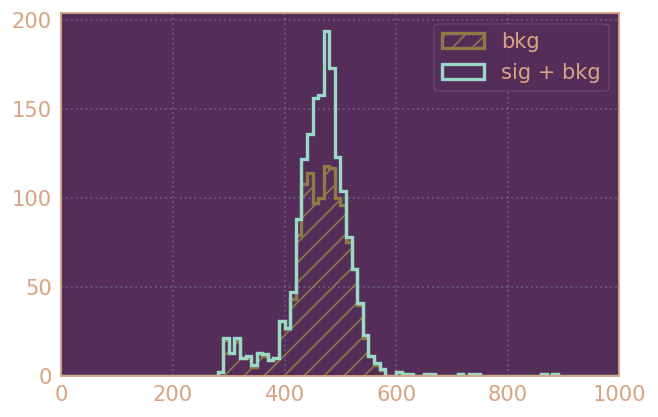

In [51]:
rng = (0, 1000)# df_ks0.psumch.max())
cumulative = 0
plt.hist(df_ks0[cut].query('finalstate_id!=8').psumch, bins=100, range=rng, cumulative=cumulative, histtype='step', lw=2, label='bkg', hatch='//');
plt.hist(df_ks0[cut].psumch, bins=100, range=rng, cumulative=cumulative, histtype='step', lw=2, label='sig + bkg');
# plt.yscale('log')
plt.legend();
plt.xlim(rng);

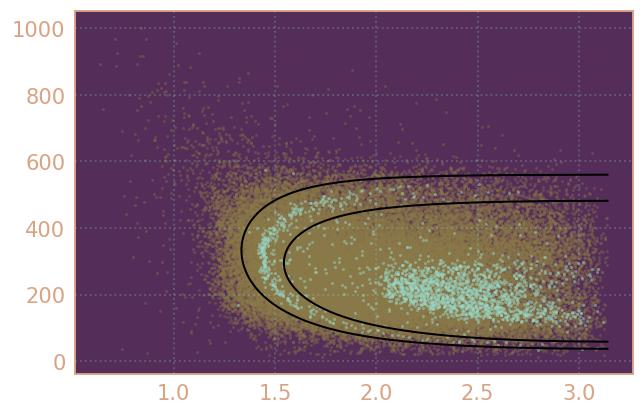

In [52]:
plt.scatter(df_ks0.query('finalstate_id!=8').ksdpsi, df_ks0.query('finalstate_id!=8').tptot_1, s=10, alpha=0.35);
# plt.scatter(df_ks0[cut].ksdpsi, df_ks0[cut].tptot_1, s=1, alpha=0.35);
plt.scatter(df_ks0.query('finalstate_id==8').ksdpsi, df_ks0.query('finalstate_id==8').tptot_0, s=10, alpha=0.5);
plt.plot(a, m, color='black')
plt.plot(ap, mp, color='black')

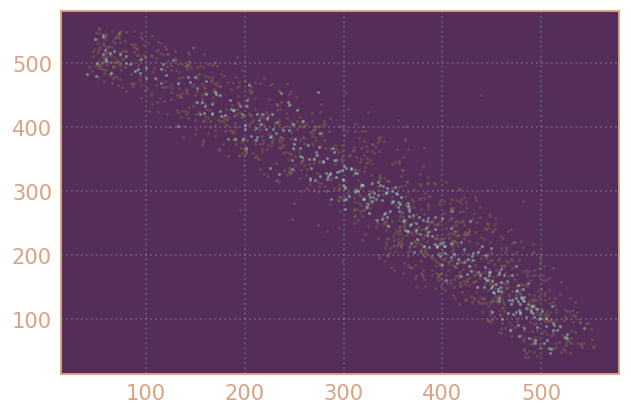

In [53]:
plt.scatter(df_ks0[cut].query('finalstate_id!=8').tptot_0, df_ks0[cut].query('finalstate_id!=8').tptot_1, s=10, alpha=0.35);
plt.scatter(df_ks0[cut].query('finalstate_id==8').tptot_0, df_ks0[cut].query('finalstate_id==8').tptot_1, s=10, alpha=0.5);

In [54]:
df_ks0[cut].finalstate_id.value_counts()

3     1061
8      347
2      141
1       63
18      56
21      45
24       5
7        5
4        4
Name: finalstate_id, dtype: int64

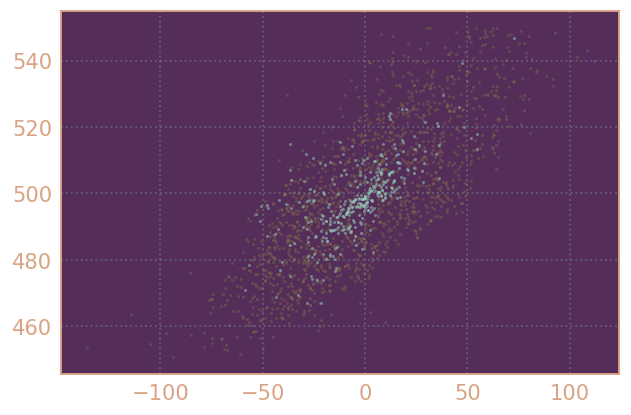

In [55]:
plt.scatter(df_ks0[cut].query('finalstate_id!=8').delta_ksptot, df_ks0[cut].query('finalstate_id!=8').ksminv, s=10, alpha=0.35);
plt.scatter(df_ks0[cut].query('finalstate_id==8').delta_ksptot, df_ks0[cut].query('finalstate_id==8').ksminv, s=10, alpha=0.5);

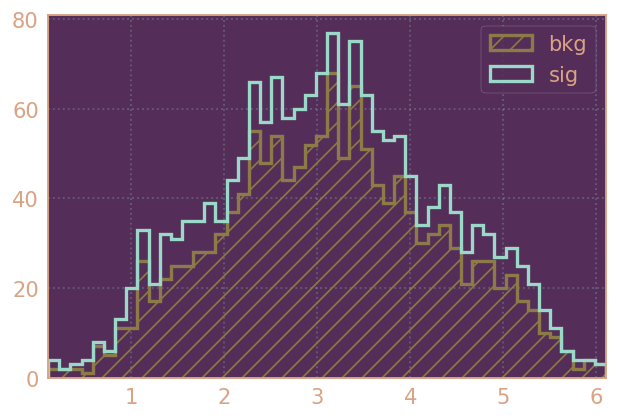

In [56]:
temp = (df_ks0[cut].tphi_1 + df_ks0[cut].tphi_0)/2#.abs(df_ks0[cut][['trho_0', 'trho_1']]).max(axis=1)
rng = (temp.min(), temp.max())
# temp = df_ks0[cut]['trho_0']**2 + df_ks0[cut]['trho_1']**2
cumulative = 0
plt.hist(temp.loc[df_ks0[cut].finalstate_id!=8], bins=50, range=rng, cumulative=cumulative, histtype='step', lw=2, label='bkg', hatch='//');
plt.hist(temp, bins=50, range=rng, cumulative=cumulative, histtype='step', lw=2, label='sig');
# plt.yscale('log')
plt.legend();
plt.xlim(rng);

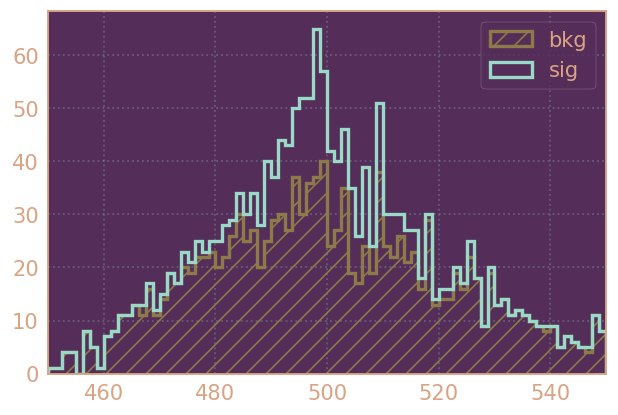

In [57]:
rng = (df_ks0.ksminv.min(), df_ks0.ksminv.max())
cumulative = 0
plt.hist(df_ks0[cut].query('finalstate_id!=8').ksminv, bins=80, range=rng, cumulative=cumulative, histtype='step', lw=2, label='bkg', hatch='//');
plt.hist(df_ks0[cut].ksminv, bins=80, range=rng, cumulative=cumulative, histtype='step', lw=2, label='sig');
# plt.yscale('log')
plt.grid(ls=':')
plt.legend();
plt.xlim(rng);

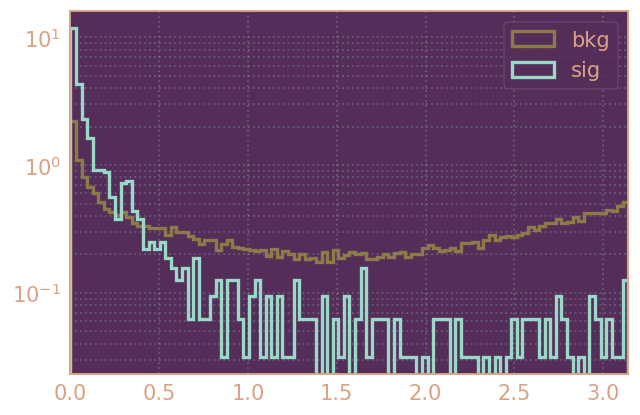

In [30]:
rng = (0, np.pi)
cumulative = 0
plt.hist(np.arccos(df_ks0.query('finalstate_id!=8').ksalign), bins=100, range=rng, cumulative=cumulative, histtype='step', lw=2, label='bkg', density=True);
plt.hist(np.arccos(df_ks0.query('finalstate_id==8').ksalign), bins=100, range=rng, cumulative=cumulative, histtype='step', lw=2, label='sig', density=True);
plt.yscale('log')
plt.grid(ls=':')
plt.legend();
# plt.ylim(0.8, 0.9)
plt.xlim(rng);

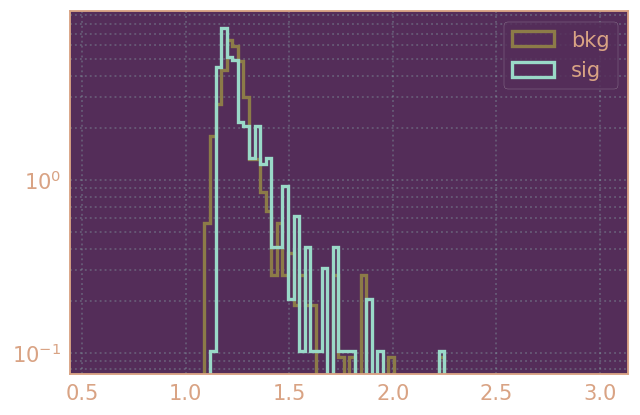

In [31]:
rng = (df_ks0.ksdpsi.min(), df_ks0.ksdpsi.max())
cumulative = 0
plt.hist(df_ks0[cut].query('finalstate_id!=8').ksdpsi, bins=100, range=rng, cumulative=cumulative, density=True, histtype='step', lw=2, label='bkg');
plt.hist(df_ks0[cut].query('finalstate_id==8').ksdpsi, bins=100, range=rng, cumulative=cumulative, density=True, histtype='step', lw=2, label='sig');
plt.yscale('log')
plt.legend();
plt.xlim(rng);

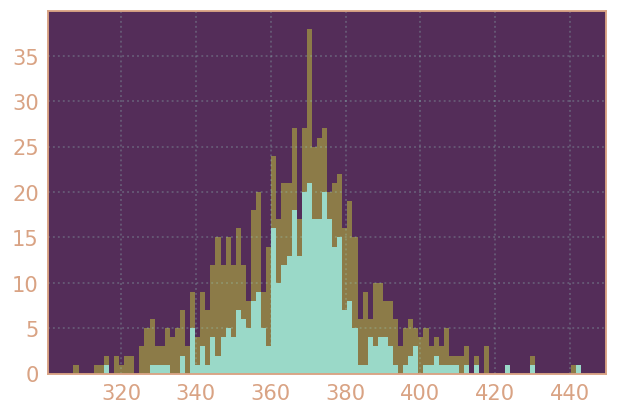

In [32]:
temp_ser = df_ks0[cut][['tptot_0', 'tptot_1']].mean(axis=1)

rng = (temp_ser.min(), temp_ser.max())
# plt.hist(df_ks.mean_pion_dp, bins=100, range=rng);
plt.hist(temp_ser, bins=100, range=rng);
plt.hist(temp_ser.loc[df_ks0[cut].finalstate_id==8], bins=100, range=rng);
# plt.yscale('log')

In [33]:
df_ks

,psumch,ksdpsi,ksalign,ksth,ksphi,finalstate_id,tth_0,tth_1,trho_0,trho_1,tptot_0,tptot_1,max_pion_dp,mean_pion_dp,max_tchi2r,max_tchi2z,min_trho,max_pidedx,max_tz
evnum,,,,,,,,,,,,,,,,,,,
147072,18.894182,2.200457,0.999980,0.762000,5.246543,10,0.937385,1.415151,1.051248,3.563258,417.434021,108.106041,266.671509,154.663986,1.014754,1.555535,1.051248,110.030518,3.305231
26269,453.766724,1.985460,0.976309,2.854378,0.869920,22,1.882144,2.373156,0.200322,0.136560,183.493103,321.230896,191.284454,122.415558,3.053100,1.281251,0.136560,540.861450,2.885390
71723,468.161224,1.528887,-0.614862,2.459833,2.517316,22,1.731691,2.503184,0.138045,0.021942,206.483261,409.542236,168.294296,101.529488,0.547746,0.936481,0.021942,1455.812988,2.102694
24413,544.610107,1.422400,-0.383542,1.183491,5.083050,3,1.770795,1.056368,0.024752,0.115468,181.255249,487.403473,193.522308,153.074112,1.555916,1.697649,0.024752,385.688232,1.297653
105948,131.580078,1.507939,0.995715,1.661571,1.818044,2,2.261482,0.852348,0.001721,0.506292,351.990479,346.319885,28.457672,25.622375,1.059029,0.558389,0.001721,357.772827,4.638622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,112.793640,1.698642,0.626477,1.711341,0.438312,2,1.143975,2.286456,0.005224,0.032367,332.801971,303.891357,70.886200,56.430893,0.926097,1.789243,0.005224,359.370117,2.930208
4366,378.610687,3.034628,0.988302,1.090202,1.891970,22,1.753792,1.240915,0.731115,0.059905,175.158005,299.786011,199.619553,137.305542,0.696010,1.423191,0.059905,210.217529,2.546510
31346,83.796806,1.677752,0.923126,0.959011,3.686826,2,1.030241,1.362482,0.017688,0.013375,417.461151,238.056686,136.720871,89.702232,1.068647,1.962549,0.013375,282.705688,0.179668


In [34]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
# from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

In [35]:
clf = DecisionTreeClassifier(max_depth=5, class_weight='balanced', criterion='gini')
# clf = RandomForestClassifier(max_depth=3, class_weight='balanced')

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_ks.drop('finalstate_id', axis=1), ((df_ks['finalstate_id']==8)), test_size=0.33, random_state=42)

In [37]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5)

In [38]:
acc_train = accuracy_score(y_train, clf.predict(X_train))
y_pred = clf.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print(f'train_acc: {acc_train:.3f}, test acc: {acc_test:.3f}')

train_acc: 0.900, test acc: 0.893


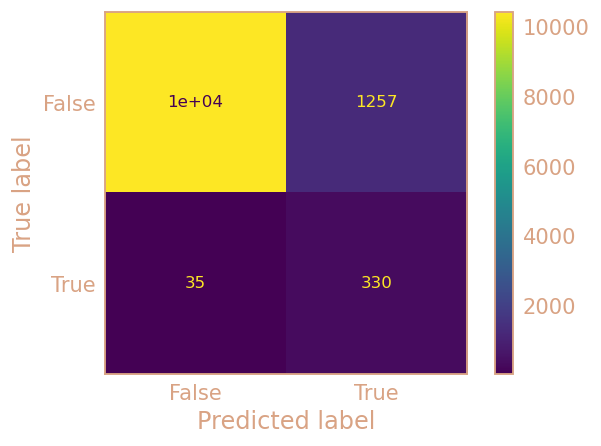

In [40]:
plot_confusion_matrix(clf, X_test, y_test);
plt.grid();

In [271]:
y_pred.sum(), y_pred.size

(169, 606)

In [272]:
y_test.sum(), y_test.size

(121, 606)

In [273]:
df_ks.drop('finalstate_id', axis=1).columns

Index(['ksdpsi', 'ksalign', 'ksth', 'ksphi', 'max_pion_dp', 'mean_pion_dp',
       'max_tchi2r', 'max_tchi2z', 'max_pidedx', 'max_tz'],
      dtype='object')

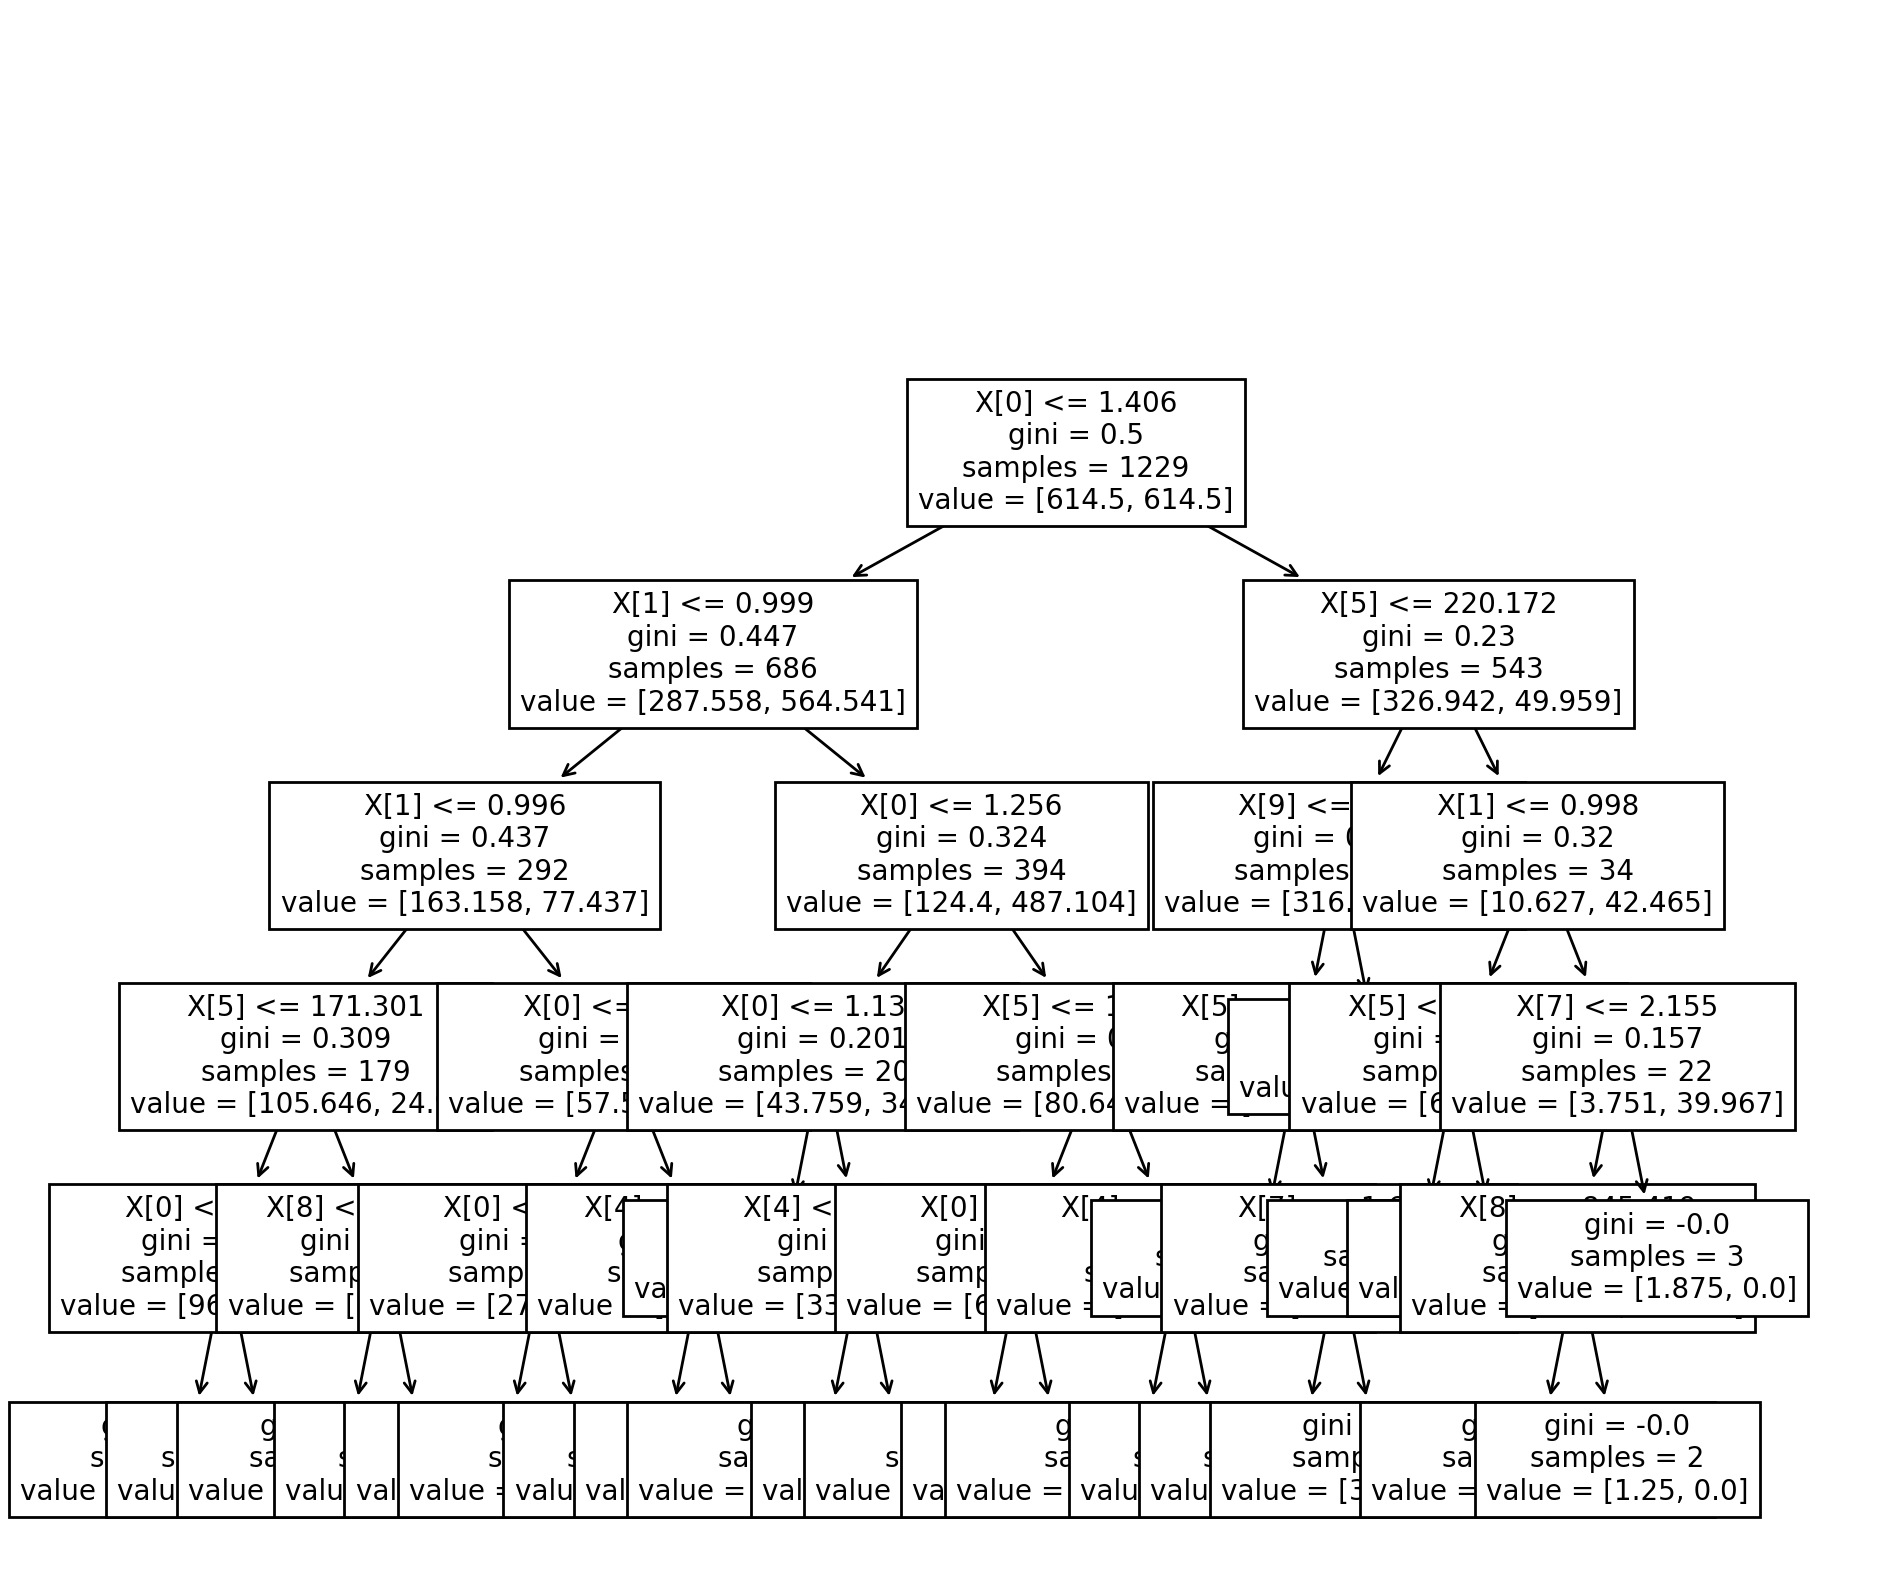

In [274]:
plt.figure(figsize=(10, 8), dpi=200, tight_layout=True)
plot_tree(clf, fontsize=10);

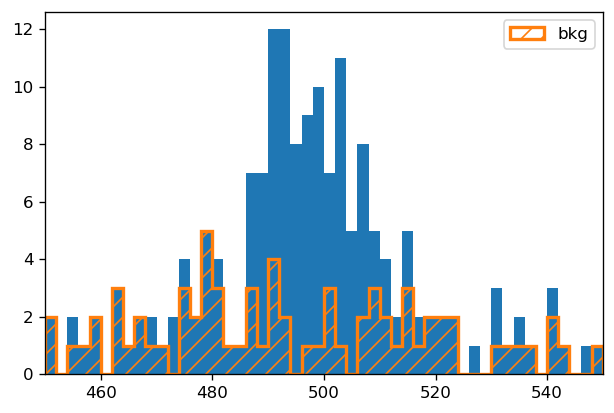

In [275]:
bins, rng = 50, (450, 550)
plt.hist(df_ks0.loc[X_test[y_pred].index].ksminv, bins=bins, range=rng);
plt.hist(df_ks0.loc[X_test[y_pred].index].query('finalstate_id!=8').ksminv, bins=bins, range=rng, histtype='step', lw=2, hatch='//', label='bkg');
plt.xlim(rng)
plt.legend();

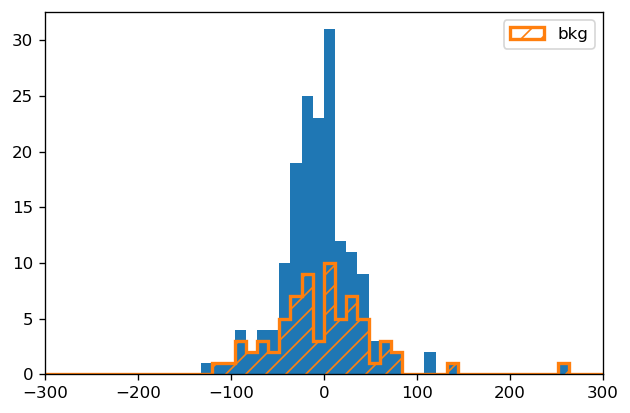

In [276]:
bins, rng = 50, (-300, 300)
plt.hist(df_ks0.loc[X_test[y_pred].index].delta_ksptot, bins=bins, range=rng);
plt.hist(df_ks0.loc[X_test[y_pred].index].query('finalstate_id!=8').delta_ksptot, bins=bins, range=rng, histtype='step', lw=2, hatch='//', label='bkg');
plt.xlim(rng)
plt.legend();

In [277]:
df_ks0

,psumch,ksptot,ksdpsi,ksalign,ksth,ksphi,ksminv,delta_ksptot,finalstate_id,tth_0,...,pidedx_0,pidedx_1,deltap_0,deltap_1,tchi2r_0,tchi2r_1,tchi2z_0,tchi2z_1,trho_0,trho_1
evnum,,,,,,,,,,,,,,,,,,,,,
147072,18.894182,363.778839,2.200457,0.999980,0.762000,5.246543,497.605194,-262.436981,10,0.937385,...,-15.881592,110.030518,42.656464,-266.671509,1.014754,0.701869,0.939433,1.555535,-1.051248,3.563258
26269,453.766724,298.395447,1.985460,0.976309,2.854378,0.869920,497.593933,-327.820374,22,1.882144,...,287.261230,540.861450,-191.284454,-53.546661,0.433990,3.053100,1.281251,0.874927,-0.200322,0.136560
71723,468.161224,466.464996,1.528887,-0.614862,2.459833,2.517316,497.608368,-159.750824,22,1.731691,...,-41.484619,-1455.812988,-168.294296,34.764679,0.474002,0.547746,0.627876,0.936481,-0.138045,-0.021942
24413,544.610107,551.173462,1.422400,-0.383542,1.183491,5.083050,497.610138,-75.042358,3,1.770795,...,385.688232,-316.958008,-193.522308,112.625916,0.790230,1.555916,1.567818,1.697649,-0.024752,-0.115468
105948,131.580078,447.079651,1.507939,0.995715,1.661571,1.818044,497.610626,-179.136169,2,2.261482,...,357.772827,351.598877,-22.787079,-28.457672,1.059029,0.589750,0.558389,0.074042,0.001721,0.506292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,112.793640,417.848785,1.698642,0.626477,1.711341,0.438312,549.983948,-208.367035,2,1.143975,...,359.370117,138.523926,-41.975586,-70.886200,0.705216,0.926097,1.789243,0.935852,0.005224,0.032367
4366,378.610687,125.232292,3.034628,0.988302,1.090202,1.891970,549.986389,-500.983521,22,1.753792,...,-210.217529,112.033691,-199.619553,-74.991547,0.696010,0.638488,1.423191,0.707484,0.731115,-0.059905
31346,83.796806,456.679504,1.677752,0.923126,0.959011,3.686826,549.990479,-169.536316,2,1.030241,...,282.705688,-94.773682,42.683594,-136.720871,1.068647,0.480955,1.962549,1.039847,0.017688,-0.013375


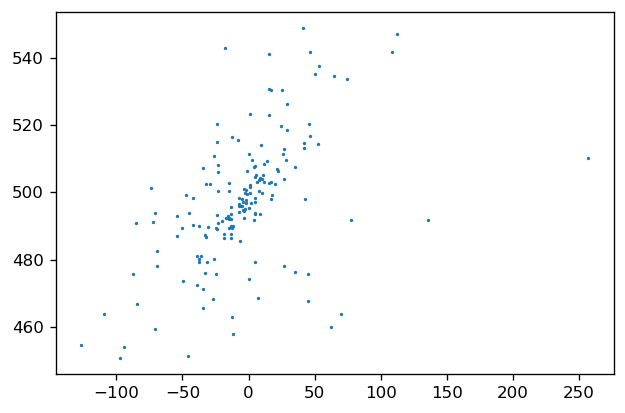

In [278]:
plt.scatter(df_ks0.loc[X_test[y_pred].index].delta_ksptot, df_ks0.loc[X_test[y_pred].index].ksminv, s=1)
# plt.xlim(500, 800)